## Modules and libraries 

In [1]:
from cellpose import models, io
from cellpose.io import *
from collections import defaultdict
import geopandas
import glob
import imagej
from jpype import JArray, JInt
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import re
import pandas
from pandas import DataFrame
from pathlib import Path
import scyjava
import seaborn
import shutil
import tkinter as tk
from tkinter import filedialog
from PIL import Image
import sys
import os

## ImageJ initialization
If under macOS, the interactive mode is not compatible and will yield an error message so it must be removed. 

In [2]:
scyjava.config.add_option('-Xmx30g')
start_dir = os.getcwd()
ij = imagej.init('sc.fiji:fiji', mode='interactive')
## Something about this init() function changes the current working directory.
ij.getApp().getInfo(True)
ij.ui().showUI()
os.chdir(start_dir)
ij.getVersion() #This is to make sure ImageJ/Fiji opened properly. In case of error, it could display '2.9.0/inactive' instead of the full version number

'2.14.0/1.54f'

ZeissCZIReader initializing /home/saka/Documents/Lab_stuff/confocal/20240508 thp1lc3 autoF/dcomp/Experiment-1867.czi
Saving image /home/saka/Documents/Lab_stuff/confocal/20240508 thp1lc3 autoF/dcomp/Experiment-1867-1.tif.
ZeissCZIReader initializing /home/saka/Documents/Lab_stuff/confocal/20240508 thp1lc3 autoF/dcomp/Experiment-1868.czi
Saving image /home/saka/Documents/Lab_stuff/confocal/20240508 thp1lc3 autoF/dcomp/Experiment-1868-1.tif.
ZeissCZIReader initializing /home/saka/Documents/Lab_stuff/confocal/20240508 thp1lc3 autoF/dcomp/Experiment-1870.czi
Saving image /home/saka/Documents/Lab_stuff/confocal/20240508 thp1lc3 autoF/dcomp/Experiment-1870-1.tif.
ZeissCZIReader initializing /home/saka/Documents/Lab_stuff/confocal/20240508 thp1lc3 autoF/dcomp/Experiment-1869.czi
Saving image /home/saka/Documents/Lab_stuff/confocal/20240508 thp1lc3 autoF/dcomp/Experiment-1869-1.tif.
ZeissCZIReader initializing /home/saka/Documents/Lab_stuff/confocal/20240508 thp1lc3 autoF/dcomp/Experiment-1872

In [3]:
showPolygonRoi = scyjava.jimport('ij.gui.PolygonRoi')
Overlay = scyjava.jimport('ij.gui.Overlay')
Regions = scyjava.jimport('net.imglib2.roi.Regions')
LabelRegions = scyjava.jimport('net.imglib2.roi.labeling.LabelRegions')
ZProjector = scyjava.jimport('ij.plugin.ZProjector')()
ov = Overlay()

## Choice of directory
This ask for the parent directory containing of all your subfolders with the image in it

In [4]:
root = tk.Tk()
root.withdraw()
directory_path = filedialog.askdirectory()

## Creation of individual images with single Z in the T-PMT channel
Depending on you image acquisition parameter or microscope used, the channel number can be adjusted to match your image channel containing the transmitted light images. 
You can change the `wanted_channel` number accordingly. For the `wanted_z`, this has to be adjusted to find the Z in your experiment that can give a good contrasted image that cellpose can succesfully segment. 

In [5]:
# Get a list of all the folders in the directory
folder_list = os.listdir(directory_path)
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
    # Find all the ".czi" files in the folder
    file_pattern = os.path.join(folder_path, "*.czi")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        image = ij.io().open(file_path)
        wanted_channel = 2
        wanted_z = 4
        wanted_image = image[:, :, wanted_channel, wanted_z]
        result_path = os.path.splitext(file_path)[0] + "-1.tif"
        cellpose_image = ij.py.to_dataset(wanted_image)
        ij.io().save(cellpose_image, result_path)
        print(f"Saving image {result_path}.")

[java.lang.Enum.toString] ZeissCZIReader initializing /home/saka/Documents/Lab_stuff/confocal/20240508 thp1lc3 autoF/dcomp/Experiment-1867.czi
[WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[java.lang.Enum.toString] [WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[WARN] Unknown DetectorType value 'Multialkali-PMT' will be stored as "Other"
[java.lang.Enum.toString] [WARN] Unknown DetectorType value 'Multialkali-PMT' will be stored as "Other"
[WARN] Unknown DetectorType value 'Multialkali-PMT' will be stored as "Other"
[java.lang.Enum.toString] [WARN] Unknown DetectorType value 'Multialkali-PMT' will be stored as "Other"
[java.lang.Enum.toString] ZeissCZIReader initializing /home/saka/Documents/Lab_stuff/confocal/20240508 thp1lc3 autoF/dcomp/Experiment-1868.czi
[WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[java.lang.Enum.toString] [WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[WARN] Unk

## Cellpose segmentation
Depending on your cellpose installation, `gpu=False` can be turned in `true` if cuda has been installed and working. `model_type=''` is to be filled with your model name (see the example below), if the model has been trained or used in the cellpose GUI that you have locally installed. If it's a new Cellpose installation and you want to use your own model, replace `model_type` by `pretrained_model='/full/path/to/model'`. Be sure the path is accurate. 

In [ ]:
model = models.CellposeModel(gpu=True, model_type='CP_20220523_104016')
files = get_image_files(directory_path, look_one_level_down=True)
imgs = [imread(f) for f in files]
nimg = len(imgs)
channels = [[0,0]]
masks, flows, styles = model.eval(imgs, diameter=None, channels=channels)
io.save_to_png(imgs, masks, flows, files)

In [6]:
folder_list = os.listdir(directory_path)
rm = ij.RoiManager.getRoiManager()
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
    # Find all the ".czi" files in the folder
    file_pattern = os.path.join(folder_path, "*-1.tif")
    file_list = glob.glob(file_pattern)
    model = models.CellposeModel(gpu=True, model_type='Raw_63x')
    for file_path in file_list:
        imgs = io.imread(file_path)
        channels = [[0,0]]
        masks, flows, styles = model.eval(imgs, diameter=90, channels=channels)
        io.save_to_png(imgs, masks, flows, file_path)

In [7]:
folder_list = os.listdir(directory_path)
rm = ij.RoiManager.getRoiManager()
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
    # Find all the ".czi" files in the folder
    file_pattern = os.path.join(folder_path, "*-1.tif")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        image_red = ij.io().open(file_path)
        imp = ij.py.to_imageplus(image_red)
        f_name = os.path.basename(file_path)
        f_name = os.path.splitext(f_name)[0]
        input_txt = Path(f"{folder_path}/{f_name}_cp_outlines.txt")
        txt_fh = open(input_txt, 'r')
        for line in txt_fh:
            xy = line.rstrip().split(",")
            xy_coords = [int(element) for element in xy if element not in '']
            x_coords = [int(element) for element in xy[::2] if element not in '']
            y_coords = [int(element) for element in xy[1::2] if element not in '']
            xcoords_jint = JArray(JInt)(x_coords)
            ycoords_jint = JArray(JInt)(y_coords)
            polygon_roi_instance = scyjava.jimport('ij.gui.PolygonRoi')
            roi_instance = scyjava.jimport('ij.gui.Roi')
            imported_polygon = polygon_roi_instance(xcoords_jint, ycoords_jint, len(x_coords), int(roi_instance.POLYGON))
            imp.setRoi(imported_polygon)
            rm.addRoi(imported_polygon)
        ij.py.run_macro("roiManager('Select All');")
        rm.runCommand("Save", f"{folder_path}/" + f"{f_name}.zip")
        ij.py.run_macro("roiManager('Select All');")
        rm.runCommand("Delete")

## Quantification
- first step is to rename the text file from the cellpose output (containing ImageJ ROIs) to facilitate further automation
- Second steps is to generate the z-projection "sum" of the channel containing the fluorescent probe signal. Adjust the `wanted_channel` number to your channel containing the probe. The image will be saved with the extension "_green.tif" because most of our probe are green, but change it if you want, free country.
- Last step is to open the "green" channel image generated earlier, and open its respective cellpose output text file. Then the ROIs are created from the text files and applied on the image and saved as a zip file matching the name of the image. This is to be able to recall the ROIs on demand from imageJ outside of this notebook. Finally, each ROIs are individually selected and the integrated density of fluorescence measured for each cell. The measurement is repeated for each images contained in the folder and pooled in a table that is saved with the name of the folder. 

In [ ]:
folder_list = os.listdir(directory_path)
# Iterate over the folders and process each folder
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
    file_prefix = "Image "  # Specify the common prefix of the files

# Regular expression pattern to match the number in the filename
    pattern = re.compile(rf"{file_prefix}(\d+)-1_cp_outlines\.txt", re.IGNORECASE)

# Iterate over the files in the folder
    for filename in os.listdir(folder_path):
    # Check if the file matches the desired pattern
        match = pattern.match(filename)
        if match:
        # Extract the number from the filename
            current_number = int(match.group(1))
        # Construct the new filename with the updated number
            new_filename = f"{file_prefix}{current_number}_green_cp_outlines.txt"
        # Create the full file paths for the old and new filenames
            old_filepath = os.path.join(folder_path, filename)
            new_filepath = os.path.join(folder_path, new_filename)
        # Rename the file
            os.rename(old_filepath, new_filepath)
            print(f"Renamed file: {filename} -> {new_filename}")

In [ ]:
# Z-projection method. Can be change to 'sum' or other as needed. 
method = 'sum'

# Get a list of all the folders in the directory
folder_list = os.listdir(directory_path)

# Iterate over the folders and process each folder
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)

    # Find all the ".czi" files in the folder
    file_pattern = os.path.join(folder_path, "*.czi")
    file_list = glob.glob(file_pattern)

    for file_path in file_list:
        image = ij.io().open(file_path)
        wanted_channel = 2
        green_channel = image[:, :, wanted_channel,:]
        imp = ij.py.to_imageplus(green_channel)
        z_projector_result = ZProjector.run(imp, method)
        z_collapsed_image = ij.py.from_java(z_projector_result)
        z_collapsed_dataset = ij.py.to_dataset(z_collapsed_image)  

    # Save the results, add a suffix "bact" for bacterial channel
        result_path = os.path.splitext(file_path)[0] + "_green.tif"

    # Save as a TIFF image
        ij.io().save(z_collapsed_dataset, result_path)
        print(f"Saving image {result_path}.")

In [ ]:
folder_list = os.listdir(directory_path)
rm = ij.RoiManager.getRoiManager()

# Iterate over the folders and process each folder
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)

    # Find all the z-projected nuclear files in the folder
    file_pattern = os.path.join(folder_path, "*.czi")
    file_list = glob.glob(file_pattern)
    
    for file_path in file_list:
        f_name = os.path.basename(file_path)
        f_name = os.path.splitext(f_name)[0]
        image_path = f"{folder_path}/{f_name}_green.tif"
        image = ij.io().open(image_path)
        input_txt = Path(f"{folder_path}/{f_name}-1_cp_outlines.txt")
        txt_fh = open(input_txt, 'r')
        set_string = f'Set Measurements...'
        measure_string = f'integrated redirect=None decimal=2'
        
        ij.IJ.run(set_string, measure_string)
        roi_stats = defaultdict(list)
        ij.ui().show(image)
        #to better draw, apply and save ROIs, the image should be displayed:
        imp = ij.py.to_imageplus(image) 
        #Call of .txt cellpose output file and draw ROIs based on segmentation result, and add them in the ROI manager
        for line in txt_fh:
            xy = line.rstrip().split(",")
            xy_coords = [int(element) for element in xy if element not in '']
            x_coords = [int(element) for element in xy[::2] if element not in '']
            y_coords = [int(element) for element in xy[1::2] if element not in '']
            xcoords_jint = JArray(JInt)(x_coords)
            ycoords_jint = JArray(JInt)(y_coords)
            polygon_roi_instance = scyjava.jimport('ij.gui.PolygonRoi')
            roi_instance = scyjava.jimport('ij.gui.Roi')
            imported_polygon = polygon_roi_instance(xcoords_jint, ycoords_jint, len(x_coords), int(roi_instance.POLYGON))
            imp.setRoi(imported_polygon)
            rm.addRoi(imported_polygon)
        ij.py.run_macro("roiManager('Select All');")
        rm.runCommand("Save", f"{folder_path}/" + f"{f_name}.zip")
        Measure = """
    nbArea=roiManager("count")
    for (i=0; i<nbArea; i++) {
		roiManager("Select", i);
		run("Measure");	
	}
    array1 = newArray("0");
    for (i=1;i<roiManager("count");i++){
    array1 = Array.concat(array1,i);
    }
	roiManager("select", array1);
    roiManager("Delete");
    close("*");    
    """
        ij.py.run_macro(Measure)

    measurements = ij.ResultsTable.getResultsTable()
    measurements_table = ij.convert().convert(measurements, scyjava.jimport('org.scijava.table.Table'))
    table = ij.py.from_java(measurements_table)
    results = os.path.basename(folder_path)
    results = os.path.splitext(results)[0]
    output_path = Path(f"{folder_path}/{results}.csv")
    table.to_csv(output_path)

    ij.py.run_macro("""
selectWindow("Results");
run("Clear Results");
""")

In [ ]:
def get_lc3_rois(folder_path, directory_path, threshold_low, threshold_high, threshold_size, distance, known_scale, unit):
    '''
    This function processes every single-cell video in the input folder bact. It uses thresholding in ImageJ to detect bacterial ROIs within the video and saves them in a zip file with the cell name. 
    The function also creates and saves a CSV file of all of the bacterial ROIs for each cell video.
    '''
    rm.runCommand("Reset")
    file_pattern = os.path.join(folder_path, "*.tif")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        rm.runCommand("Reset")
        basename = os.path.basename(file_path)
        corename = os.path.splitext(basename)[0]
        if basename.startswith("LC3"):
            image_path = f"{folder_path}/{basename}"
            imp = ij.IJ.openImage(image_path)
            imp.show()
            ij.IJ.run(imp, "Smooth", "stack")
            ij.IJ.run(imp, "Smooth", "stack")
            ij.py.run_macro(f'run("Set Scale...", "distance={distance} known={known_scale} unit={unit}");')    
            ij.IJ.run("Set Measurements...", f'area centroid stack decimal=2')
            ij.IJ.setAutoThreshold(imp, "Default dark")
            ij.IJ.setRawThreshold(imp, threshold_low, threshold_high)
            ij.IJ.run(imp, "Convert to Mask", "background=Dark black");
            ij.IJ.run(imp, "Analyze Particles...", f"size={threshold_size}-Infinity display add stack");
            ij.IJ.run(imp, "Measure", "");
            rm.save(f"{folder_path}/{corename}.zip")
            output_path = Path(f"{folder_path}/{corename}.csv").as_posix()
            ij.IJ.saveAs("Results", output_path)
            ij.IJ.run("Clear Results")
            ij.py.run_macro('close("*");')
        rm.runCommand("Reset")
        #ij.IJ.selectWindow("Results")
        #ij.IJ.run("Close")

In [ ]:
# Get a list of all the folders in the directory
folder_list = os.listdir(directory_path)
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
    # Find all the ".czi" files in the folder
    file_pattern = os.path.join(folder_path, "*.czi")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        image = ij.io().open(file_path)
        LC3_channel = 0
        channel = image[:, :, LC3_channel, :]
        lc3 = ij.py.to_imageplus(channel)
        #lc3.setDimensions(1, 11, 1)
        #ij.ui().show(lc3)
        basename = os.path.basename(file_path)
        corename = os.path.splitext(basename)[0]
        result_path = f"{folder_path}/LC3_channel_{corename}.tif"
        ij.IJ.saveAs(lc3, "Tiff", ij.py.to_java(result_path))

In [ ]:
rm = ij.RoiManager.getRoiManager()
threshold_low = 10
threshold_high = 255
threshold_size = 0.1
known_scale = 224.48
distance = 1024 # scale
unit = "µm"
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
    get_lc3_rois(folder_path, directory_path, threshold_low, threshold_high, threshold_size, distance, known_scale, unit)

In [ ]:
folder_list = os.listdir(directory_path)
rm = ij.RoiManager.getRoiManager()
threshold_low = 10
threshold_high = 255
threshold_size = 0.1
known_scale = 224.48
distance = 1024 # scale
unit = "µm"
# Iterate over the folders and process each folder
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)
    file_pattern = os.path.join(folder_path, "*.czi")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        basename = os.path.basename(file_path)
        corename = os.path.splitext(basename)[0]
        image_path = f"{folder_path}/LC3_channel_{corename}.tif"
        input_ROI = Path(f"{folder_path}/{corename}-1.zip").as_posix()
        rm.open(input_ROI)
        imp = ij.IJ.openImage(image_path)
        imp.show()
        ij.IJ.run(imp, "Smooth", "stack")
        ij.IJ.run(imp, "Smooth", "stack")
        ij.py.run_macro(f'run("Set Scale...", "distance={distance} known={known_scale} unit={unit}");')    
        ij.IJ.run("Set Measurements...", f'area centroid stack decimal=2')
        ij.IJ.setAutoThreshold(imp, "Default dark")
        ij.IJ.setRawThreshold(imp, threshold_low, threshold_high)
        ij.IJ.run(imp, "Convert to Mask", "background=Dark black");
        Measure = """
        nbArea=roiManager("count")
        for (i=0; i<nbArea; i++) {
                roiManager("Select", i);
                run("Set Measurements...", "area limit redirect=None decimal=2");
                run("Analyze Particles...", "summarize stack");
        }
        title = Table.title();
        selectWindow(title);
        Table.rename(title, "Results");
        close("*");
        """
        ij.py.run_macro(Measure)
        rm.runCommand("Reset")
        ij.py.run_macro(Measure)
        output_path = Path(f"{folder_path}/LC3_channel_{corename}.csv").as_posix()
        ij.IJ.saveAs("Results", output_path)
        ij.IJ.run("Clear Results")
        # this last step is to close the result table to avoir a concatenation of the next round of results.

In [10]:
def calculate_total_volume_per_cell(df):
    """Calculates the sum of the "Total Area" for each pattern of the "Slice" column.

    Args:
        df: A pandas DataFrame containing the data.

    Returns:
        A pandas DataFrame containing the sum of the "Total Area" for each pattern of the "Slice" column.
    """

    # Create a list to store the DataFrames with results.
    results = []

    # Loop through the DataFrame.
    for i in range(len(df)):
        # If the current cell value in the "Slice" column is 1,
        if df['Slice'][i] == 1:
            # Sum the "Total Area" column for the next 10 rows.
            #slice_number = 10  # You need to define slice_number and slice_distance
            #slice_distance = 1  # You need to define slice_number and slice_distance
            bacterial_area = df['Total Area'][i:i + slice_number].sum()
            bacterial_volume = bacterial_area * slice_distance
            # Create a DataFrame with the current pattern number and the total area.
            result_df = pandas.DataFrame({'LC3_volume': [bacterial_volume]}, index=[i])
            results.append(result_df)

    # Concatenate the list of DataFrames to create the final results DataFrame.
    final_results = pandas.concat(results, ignore_index=True)

    # Return the final results DataFrame.
    return final_results

In [11]:
slice_number = 11 # Change this to the actual slice number in your image
slice_distance = 1  # Change this to the actual distance between your slices. The unit here is in micrometers
folder_list = os.listdir(directory_path)
for folder in folder_list:
    # Get the path to the folder
    folder_path = os.path.join(directory_path, folder)

    # Find all the z-projected nuclear files in the folder
    file_pattern = os.path.join(folder_path, "*.csv")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        # Read the DataFrame.
        df = pandas.read_csv(file_path)

        # Calculate the sum of the "Total Area" for each pattern of the "Slice" column.
        df = calculate_total_volume_per_cell(df)


    f_name = os.path.basename(folder_path)
    #f_name = os.path.splitext(f_name)[0]
    output_path = Path(f"{directory_path}/{f_name}.csv")
    df.to_csv(output_path)

In [13]:
csv_path = f"{directory_path}/concatenated.csv"
df = pandas.read_csv(csv_path)
df.head()

,ui,wt,desxa,dcomp
0,0.00,0.0,11.68,0.00
1,0.00,0.0,0.00,0.00
2,0.00,0.0,0.00,6.44
3,1.06,0.0,0.00,0.14
4,1.06,0.0,0.00,0.00


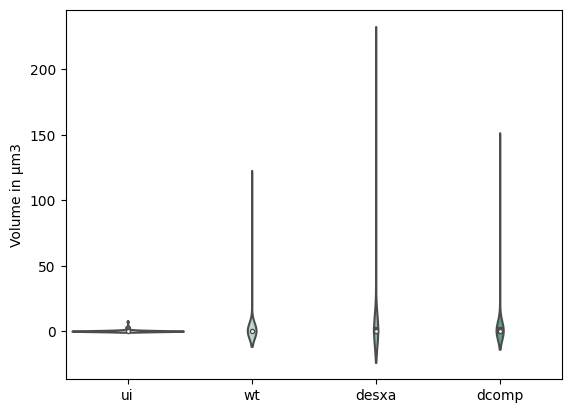

In [15]:
prout = seaborn.violinplot(data=df, width=0.9, dodge=True, palette = "light:#5A9", as_cmap=True)
plt.ylabel('Volume in µm3')
plt.show()

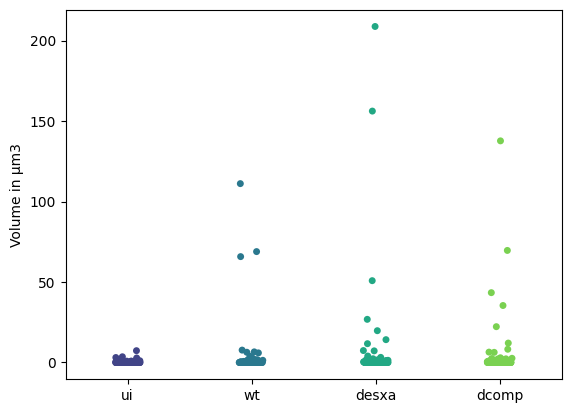

In [14]:
prout = seaborn.stripplot(data=df, palette = "viridis")
plt.ylabel('Volume in µm3')
plt.show()